In [1]:
import torch
import torchvision
import numpy as np
import random
import matplotlib.pyplot as plt
from torchsummary import summary
import math
from tqdm import tqdm # <- para graficar la barra de avance
import pickle

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [105]:
train = pickle.load( open( "train.pkl", "rb" ) )
y_train = pickle.load( open( "train_label.pkl", "rb" ) )

test = pickle.load( open( "test.pkl", "rb" ) )
y_test = pickle.load( open( "test_label.pkl", "rb" ) )

val = pickle.load( open( "val.pkl", "rb" ) )
y_val = pickle.load( open( "val_label.pkl", "rb" ) )

In [99]:
t = torch.Tensor(train)
t.permute(1, 0, 2).shape

t.shape


torch.Size([56000, 28, 28])

In [147]:
train = torch.Tensor(train).type(torch.FloatTensor)
y_train = torch.Tensor(y_train).type(torch.FloatTensor)

test = torch.Tensor(test).type(torch.FloatTensor)
y_test = torch.Tensor(y_test).type(torch.FloatTensor)

val = torch.Tensor(val).type(torch.FloatTensor)
y_val = torch.Tensor(y_val).type(torch.FloatTensor)

In [148]:
class data_set(torch.utils.data.Dataset):
    def __init__(self,X,Y):
        self.X = X                           # set data
        self.Y = Y                           # set lables

    def __len__(self):
        return len(self.X)                   # return length

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [149]:
training_dataset = data_set(train, y_train)
test_dataset = data_set(test, y_test)
val_dataset = data_set(val, y_val)


# ahora el dataloader
dataloader = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, pin_memory=True)
}

In [150]:
print(type(dataloader))
print(type(dataloader['train']))
print(len(dataloader['train'].dataset))
print(len(dataloader['test'].dataset))

<class 'dict'>
<class 'torch.utils.data.dataloader.DataLoader'>
56000
7000


In [151]:
# bloque de convolución para emplear en mi red

def conv_block(c_in, c_out, k=5, p=2, s=1, pk=5, ps=1, pp=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [153]:
class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 16)
    self.conv1_out = None
    self.conv2 = conv_block(16, 8)
    self.conv2_out = None
    self.conv3 = conv_block(8, 4)
    self.conv3_out = None
    self.conv4 = conv_block(4, 4)
    self.conv4_out = None
    self.conv5 = conv_block(4, 4)
    self.conv5_out = None
    self.conv6 = conv_block(4, 4)
    self.conv6_out = None
    self.conv7 = conv_block(4, 4)
    self.conv7_out = None
    self.conv8 = conv_block(4, 4)
    self.conv8_out = None
    self.conv9 = conv_block(4, 4)
    self.conv9_out = None
    self.conv10 = conv_block(4, 4)
    self.conv10_out = None
    self.conv11 = conv_block(4, 4)
    self.conv11_out = None
    self.conv12 = conv_block(4, 4)
    self.conv12_out = None
    self.conv13 = conv_block(4, 4)
    self.conv13_out = None
    self.fc = torch.nn.Linear(3136, n_outputs) # verificar la dim de la salida para calcular el tamaño de la fully conected!!
    
    
    print('Red creada')
    print('arquitectura:')
    print(self)
    
    # Me fijo en el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)
    
    # Me fijo en el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def n_layers(self):
    i=0
    for layer in self.children():
        i=i+1

    return i

  def n_parameters(self):
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    return pytorch_total_params

  def validar_dim(self, tam):
    print("Validacion de dimensiones")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)
    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)

    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = self.conv5(x)
    print("Tamaño salida conv5: ", x.shape)

    x = self.conv6(x)
    print("Tamaño salida conv6: ", x.shape)

    x = self.conv7(x)
    print("Tamaño salida conv7: ", x.shape)

    x = self.conv8(x)
    print("Tamaño salida conv8: ", x.shape)

    x = self.conv9(x)
    print("Tamaño salida conv9: ", x.shape)

    x = self.conv10(x)
    print("Tamaño salida conv10: ", x.shape)

    x = self.conv11(x)
    print("Tamaño salida conv11: ", x.shape)

    x = self.conv12(x)
    print("Tamaño salida conv12: ", x.shape)

    x = self.conv13(x)
    print("Tamaño salida conv13: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    self.conv5_out = self.conv5(self.conv4_out)
    self.conv6_out = self.conv6(self.conv5_out)
    self.conv7_out = self.conv7(self.conv6_out)
    self.conv8_out = self.conv8(self.conv7_out)
    self.conv9_out = self.conv9(self.conv8_out)
    self.conv10_out = self.conv10(self.conv9_out)
    self.conv11_out = self.conv11(self.conv10_out)
    self.conv12_out = self.conv12(self.conv11_out)
    self.conv13_out = self.conv13(self.conv12_out)
    # self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv13_out.view(self.conv13_out.shape[0], -1)
    y = self.fc(y)
    # x = self.sm(x)
    return y

In [161]:
def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            X = X.unsqueeze(0)
            X = X.permute(1, 0, 2, 3)
            y_hat = model(X)
            loss = criterion(y_hat, y.type(torch.LongTensor))
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")
        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))
        
        
    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.title('loss')
    plt.legend(['train loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.title('acc')
    plt.legend(['train acc'])
    plt.grid()
    plt.show()

In [163]:
def test_acc(model, dataloader):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    train_acc = []

    bar = tqdm(dataloader['test'])
    for batch in bar:
        X, y = batch
        X = X.unsqueeze(0)
        X = X.permute(1, 0, 2, 3)
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        train_acc.append(acc)
        bar.set_description(f"acc {np.mean(train_acc):.5f}")
        
    v_acc  = np.mean(train_acc)

    print(f"Test accuracy {np.mean(v_acc):.5f}")
    plt.figure()
    plt.plot(train_acc, 'r')


    return v_acc

In [114]:
def score(n_parameter, test_acc, n_layers):
    print(f"score is {n_layers * (1 / (math.log10(n_parameter)))} * accuracy")
    return test_acc * n_layers * (1 / (math.log10(n_parameter)))

In [155]:
model = CNN()
model.validar_dim(28)

Red creada
arquitectura:
CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(8, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=2, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(4, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=2, d

loss 0.04776 acc 0.98438:   0%|          | 1/875 [00:00<02:19,  6.26it/s]

Epoch 1/10 loss 0.10964 acc 0.96430


loss 0.10700 acc 0.96875:   0%|          | 1/875 [00:00<02:19,  6.27it/s]

Epoch 2/10 loss 0.10008 acc 0.96730


loss 0.10719 acc 0.96875:   0%|          | 1/875 [00:00<02:40,  5.45it/s]

Epoch 3/10 loss 0.09663 acc 0.96975


loss 0.04934 acc 0.98438:   0%|          | 1/875 [00:00<02:34,  5.67it/s]

Epoch 4/10 loss 0.09198 acc 0.96996


loss 0.14210 acc 0.95312:   0%|          | 1/875 [00:00<02:23,  6.08it/s]

Epoch 5/10 loss 0.08908 acc 0.97146


loss 0.11380 acc 0.95312:   0%|          | 1/875 [00:00<02:40,  5.45it/s]

Epoch 6/10 loss 0.08446 acc 0.97304


loss 0.05333 acc 0.96875:   0%|          | 0/875 [00:00<?, ?it/s]

Epoch 7/10 loss 0.08047 acc 0.97409


loss 0.08245 acc 0.98438:   0%|          | 1/875 [00:00<02:23,  6.08it/s]

Epoch 8/10 loss 0.07944 acc 0.97425


loss 0.09287 acc 0.96875:   0%|          | 1/875 [00:00<02:23,  6.10it/s]

Epoch 9/10 loss 0.07557 acc 0.97580


loss 0.07545 acc 0.97554: 100%|██████████| 875/875 [02:31<00:00,  5.77it/s]

Epoch 10/10 loss 0.07545 acc 0.97554


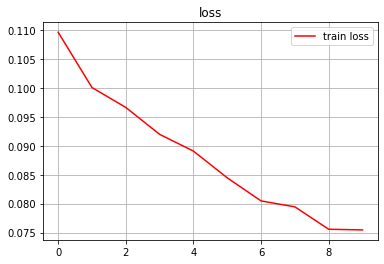

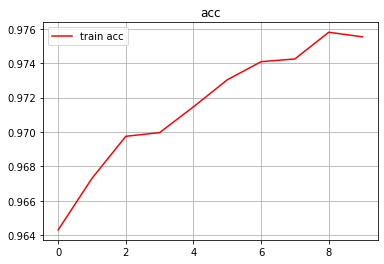

acc 0.97259: 100%|██████████| 110/110 [00:10<00:00, 10.23it/s]

Test accuracy 0.97259
score is 3.0432814219084428 * accuracy
Score 2.95985


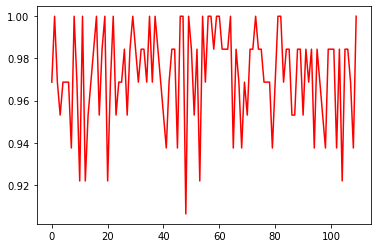

In [165]:
fit(model, dataloader, epochs=10)
accuracy = test_acc(model, dataloader)

s = score(model.n_parameters(), accuracy, model.n_layers())

print(f"Score {s:.5f}")
